In [ ]:
!pip install transformers tensorflow==2.15 imblearn nltk==3.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AdamWeightDecay
from transformers import AutoTokenizer
from sklearn.utils import resample
from transformers import AdamWeightDecay
from tensorflow.keras.layers import Dropout
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/NLP/clickbait_title.csv", sep=',',
                         usecols=['title', 'label', 'label_score'],
                         names=['title', 'label', 'label_score'],
                         engine='python',
                         encoding='latin-1')

In [ ]:
train_data.head()

,title,label,label_score
0,title,label,label_score
1,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
2,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
3,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
4,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0


In [ ]:
train_data['label'].unique()

array(['label', 'non-clickbait', 'clickbait'], dtype=object)

In [ ]:
train_data = train_data[train_data['label'] != 'label']
train_data['label'].value_counts()


,count
label,
non-clickbait,8710
clickbait,6290


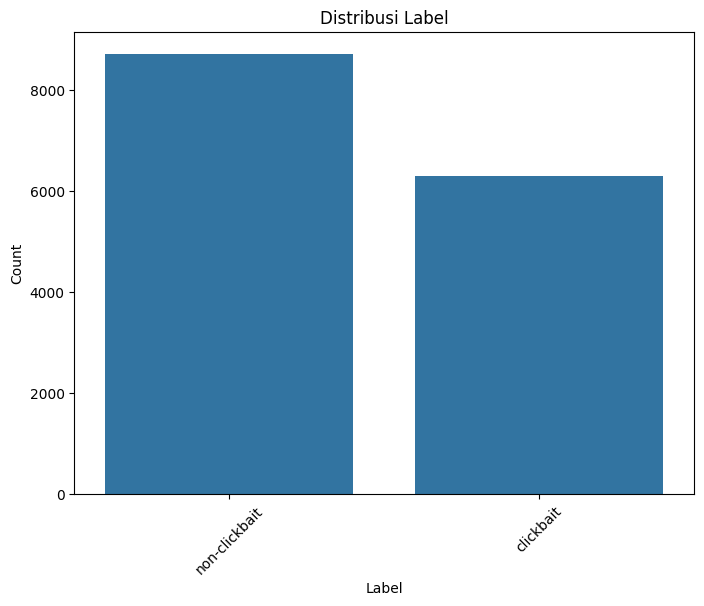

In [ ]:
# Distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data)
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):

    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters and symbols
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace

    text = ' '.join([word for word in text.split() if word not in stop_words]) #Inisialisasi

    return text

# Example usage (assuming 'train_data' is your DataFrame)
train_data['cleaned_title'] = train_data['title'].apply(clean_text)
train_data.head()

,title,label,label_score,cleaned_title,tokenized_title
1,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0,masuk radar pilwalkot medan menantu jokowi ber...,"[2, 804, 13379, 2726, 27696, 105, 3250, 22635,..."
2,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0,malaysia sudutkan ri isu kabut asap invasi babi,"[2, 4891, 4169, 32, 949, 5451, 15385, 7800, 73..."
3,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1,viral driver ojol bekasi pesanan makanan pakai...,"[2, 19946, 8794, 412, 18456, 26, 3661, 2563, 6..."
4,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0,kemensos salurkan rp m korban kerusuhan sosial...,"[2, 5037, 14064, 866, 1579, 600, 8, 396, 2457,..."
5,"Terkait Mayat Bayi Mengenaskan di Tangerang, S...",non-clickbait,0,terkait mayat bayi mengenaskan tangerang pria ...,"[2, 1780, 9646, 1625, 753, 1656, 26, 4078, 596..."


In [ ]:
# Load the IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize the cleaned titles
train_data['tokenized_title'] = train_data['cleaned_title'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

train_data.head()

,title,label,label_score,cleaned_title,tokenized_title
1,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0,masuk radar pilwalkot medan menantu jokowi ber...,"[2, 804, 13379, 2726, 27696, 105, 3250, 22635,..."
2,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0,malaysia sudutkan ri isu kabut asap invasi babi,"[2, 4891, 4169, 32, 949, 5451, 15385, 7800, 18..."
3,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1,viral driver ojol bekasi pesanan makanan pakai...,"[2, 19946, 8794, 412, 18456, 3661, 6012, 955, ..."
4,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0,kemensos salurkan rp m korban kerusuhan sosial...,"[2, 5037, 14064, 866, 1579, 600, 8, 2457, 1432..."
5,"Terkait Mayat Bayi Mengenaskan di Tangerang, S...",non-clickbait,0,terkait mayat bayi mengenaskan tangerang pria ...,"[2, 1780, 9646, 1625, 753, 1656, 4078, 1380, 7..."


In [ ]:
# Separate features (X) and target variable (y)
X = train_data['tokenized_title']
y = train_data['label']

# Split data into training and testing sets (70:30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 10500
Testing data size: 4500


In [ ]:
# Determine the maximum sequence length
max_length = max(len(seq) for seq in X_train)

# Pad sequences to the maximum length
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numerical format
label_mapping = {label: i for i, label in enumerate(np.unique(y_train))}  # Create label mapping
y_train_encoded = np.array([label_mapping[label] for label in y_train])
y_test_encoded = np.array([label_mapping[label] for label in y_test])


# Load pre-trained IndoBERT model for sequence classification
model = TFAutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=len(np.unique(y_train)))

# Instead of directly using the model, create a Keras layer
# This will handle the input processing and type checking
class IndoBERTLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        super(IndoBERTLayer, self).__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        # Get the logits from the IndoBERT model
        outputs = self.model(inputs).logits
        return outputs

# Create an instance of the custom layer
indobert_layer = IndoBERTLayer(model)

# Extract the logits tensor from the IndoBERT output using the custom layer
inputs = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
outputs = indobert_layer(inputs)  # Get the logits

# Apply Dropout to the logits
dropout_output = Dropout(0.5)(outputs)

# Add the final Dense layer
final_output = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.1))(dropout_output)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=final_output)

# Compile the model
optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.1) # Add weight decay rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=optimizer.learning_rate, weight_decay=optimizer.weight_decay_rate) # Wrap with tf.keras.optimizers.AdamW

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(
    X_train_padded,  # Input features
    y_train_encoded,  # Target labels
    epochs=9,        # Number of training epochs
    batch_size=32,    # Batch size for training
    validation_split=0.2  # Fraction of data for validation
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

tf_model.h5:  82%|########1 | 535M/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


263/263 [==============================] - 128s 263ms/step - loss: 0.9048 - accuracy: 0.6426 - val_loss: 0.8502 - val_accuracy: 0.7167
Epoch 2/9
263/263 [==============================] - 58s 221ms/step - loss: 0.8537 - accuracy: 0.6976 - val_loss: 0.7958 - val_accuracy: 0.7624
Epoch 3/9
263/263 [==============================] - 59s 224ms/step - loss: 0.8380 - accuracy: 0.7138 - val_loss: 0.7866 - val_accuracy: 0.7667
Epoch 4/9
263/263 [==============================] - 59s 226ms/step - loss: 0.8237 - accuracy: 0.7242 - val_loss: 0.7892 - val_accuracy: 0.7552
Epoch 5/9
263/263 [==============================] - 58s 222ms/step - loss: 0.8089 - accuracy: 0.7326 - val_loss: 0.7609 - val_accuracy: 0.7719
Epoch 6/9
263/263 [==============================] - 59s 226ms/step - loss: 0.7884 - accuracy: 0.7449 - val_loss: 0.7601 - val_accuracy: 0.7695
Epoch 7/9
263/263 [==============================] - 58s 222ms/step - loss: 0.7777 - accuracy: 0.7471 - val_loss: 0.7578 - val_accuracy: 0.7710
E

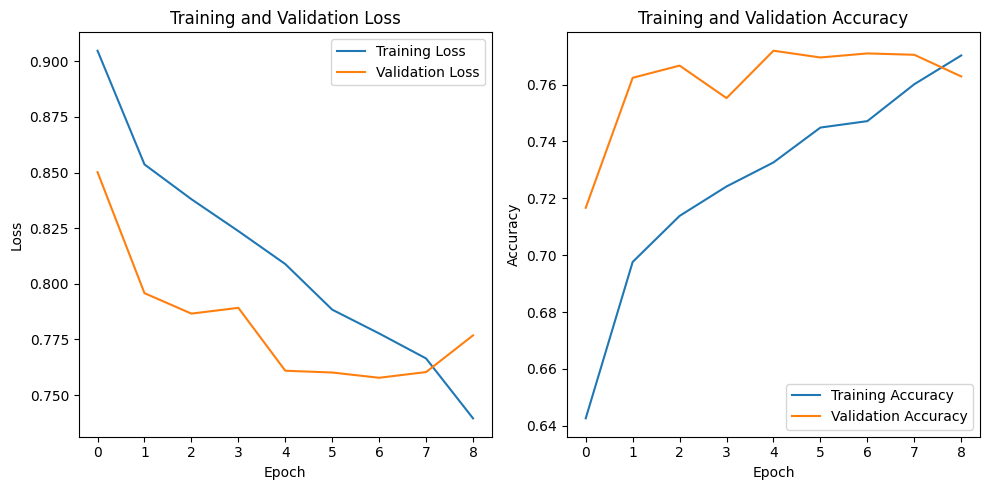

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)

# Further evaluation metrics (e.g., classification report)
print(classification_report(y_test_encoded, y_pred_labels))

141/141 [==============================] - 18s 64ms/step
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1887
           1       0.80      0.77      0.78      2613

    accuracy                           0.75      4500
   macro avg       0.74      0.75      0.75      4500
weighted avg       0.75      0.75      0.75      4500



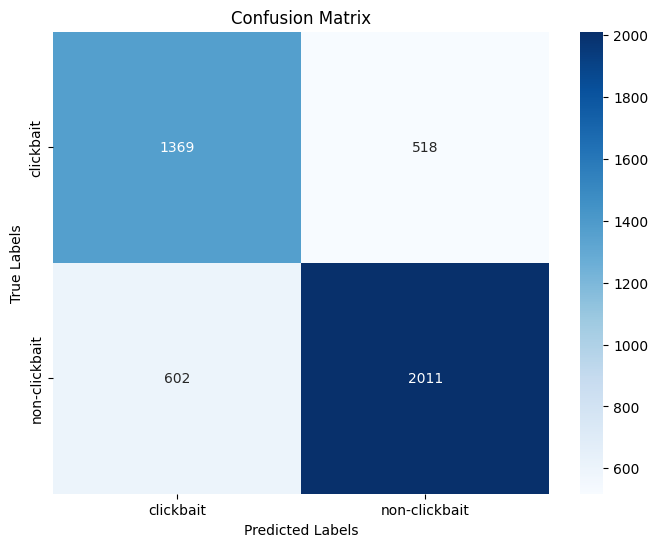

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()